Notebook by Zara

## **Faster R-CNN on small custom dataset**

Experiment 2: data augmentation, stratified sampling, shuffling

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models  # Import models from TensorFlow
import imgaug.augmenters as iaa
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

``Read data and folder path``

In [2]:
data = pd.read_excel('/Users/zaravanthoff/Desktop/data/annotations_cleaned_more.xlsx')

In [3]:
folder_path = "/Users/zaravanthoff/Desktop/data/images"

In [4]:
data

,Brand,Image,Xmin,Xmax,Ymin,Ymax,Class,ObjectWidth,ObjectHeight,Image Width,Image Height
0,ABN AMRO,1843248.JPG,1755,2385,4452,4649,0,630,197,3409,4900
1,ABN AMRO,1820597.JPG,1589,2212,4320,4590,0,623,270,3152,4708
2,ABN AMRO,1818130.JPG,2346,3038,2011,2189,0,692,178,3114,2230
3,ABN AMRO,18637600_01.JPG,2032,2423,2940,3042,0,391,102,2608,3232
4,ABN AMRO,1814797.JPG,2991,3102,392,506,0,111,114,3147,539
...,...,...,...,...,...,...,...,...,...,...,...
590,TUI,1844444.JPG,145,1941,9,1150,16,1796,1141,3193,2207
591,TUI,18614610_01.JPG,2695,3047,100,261,16,352,161,3146,2200
592,TUI,1854527.JPG,1160,1349,58,151,16,189,93,1422,1029
593,TUI,18606990_01.JPG,2699,3043,106,268,16,344,162,3147,2203


``Preprocess data``

**Resizing**

In [5]:
import cv2
import os
import pandas as pd
import numpy as np

def preprocess_data(data, folder_path, target_width=416, target_height=416):
    """
    Preprocesses images and labels from the given DataFrame.
    
    Args:
        data (DataFrame): DataFrame containing image filenames, labels, and bounding box coordinates.
        folder_path (str): Path to the folder containing the images.
        target_width (int): Target width for resizing the images.
        target_height (int): Target height for resizing the images.
    
    Returns:
        tuple: Tuple containing preprocessed images, labels, and adjusted bounding box coordinates.
    """
    resized_images = []
    labels = []
    adjusted_bboxes = []  # List to store adjusted bounding box coordinates

    # Iterate through each row in the dataset
    for index, row in data.iterrows():
        # Extract image filename from the dataset
        image_filename = row['Image']  # Accessing by column name
        
        # Construct the full path to the image
        image_path = os.path.join(folder_path, image_filename)
        
        try:
            # Read the image using OpenCV
            image = cv2.imread(image_path)
            
            # Check if the image was read successfully
            if image is None:
                raise FileNotFoundError(f"Unable to read image at path: {image_path}")
            
            # Resize the image to the target size
            resized_image = cv2.resize(image, (target_width, target_height))
            
            # Append resized image to the list
            resized_images.append(resized_image)
            
            # Append label to the list (assuming label is in the 'Class' column of the dataframe)
            label = row['Class']
            labels.append(label)
            
            # Adjust bounding box coordinates
            xmin = int(row['Xmin'] * (target_width / image.shape[1]))
            ymin = int(row['Ymin'] * (target_height / image.shape[0]))
            xmax = int(row['Xmax'] * (target_width / image.shape[1]))
            ymax = int(row['Ymax'] * (target_height / image.shape[0]))
            adjusted_bboxes.append((xmin, ymin, xmax, ymax))
            
            print(f"Image processed successfully: {image_filename}")
        except Exception as e:
            print(f"Error processing image at path {image_path}: {str(e)}")

    return np.array(resized_images), np.array(labels), np.array(adjusted_bboxes)

def compute_bbox_deltas(data, adjusted_bboxes):
    """
    Computes bounding box deltas based on adjusted bounding box coordinates and ground truth bounding box coordinates.

    Args:
        data (DataFrame): DataFrame containing ground truth bounding box coordinates.
        adjusted_bboxes (numpy array): Array containing adjusted bounding box coordinates.

    Returns:
        numpy array: Array containing bounding box deltas.
    """
    bbox_deltas = []
    for index, row in data.iterrows():
        xmin_true = row['Xmin']
        ymin_true = row['Ymin']
        xmax_true = row['Xmax']
        ymax_true = row['Ymax']

        xmin_adjusted, ymin_adjusted, xmax_adjusted, ymax_adjusted = adjusted_bboxes[index]

        dx = (xmin_true - xmin_adjusted) / (xmax_true - xmin_adjusted)
        dy = (ymin_true - ymin_adjusted) / (ymax_true - ymin_adjusted)
        dw = np.log((xmax_true - xmin_true) / (xmax_adjusted - xmin_adjusted))
        dh = np.log((ymax_true - ymin_true) / (ymax_adjusted - ymin_adjusted))

        bbox_deltas.append([dx, dy, dw, dh])

    return np.array(bbox_deltas)

In [6]:
# Preprocess images and labels
resized_images, labels, adjusted_bboxes = preprocess_data(data, folder_path)

Image processed successfully: 1843248.JPG
Image processed successfully: 1820597.JPG
Image processed successfully: 1818130.JPG
Image processed successfully: 18637600_01.JPG
Image processed successfully: 1814797.JPG
Image processed successfully: 1817506.JPG
Image processed successfully: 19404960_01.JPG
Image processed successfully: 18652740_01.JPG
Image processed successfully: 19457660_01.JPG
Image processed successfully: 1814903.JPG
Image processed successfully: 1844629.JPG
Image processed successfully: 1816345.JPG
Image processed successfully: 1818046.JPG
Image processed successfully: 18968450_01.JPG
Image processed successfully: 19284810_01.JPG
Image processed successfully: 1816316.JPG
Image processed successfully: 1825838.JPG
Image processed successfully: 1844443.JPG
Image processed successfully: 19466380_01.JPG
Image processed successfully: 19077290_01.JPG
Image processed successfully: 1814804.JPG
Image processed successfully: 1816911.JPG
Image processed successfully: 1805578.JPG
Im

**Normalize pixels**

In [7]:
# Normalize pixel values
resized_images = resized_images.astype('float32') / 255.0

# Check the range of pixel values after normalization
print("Minimum Pixel Value After Normalization:", np.min(resized_images))
print("Maximum Pixel Value After Normalization:", np.max(resized_images))

Minimum Pixel Value After Normalization: 0.0
Maximum Pixel Value After Normalization: 1.0


**Augmentation**

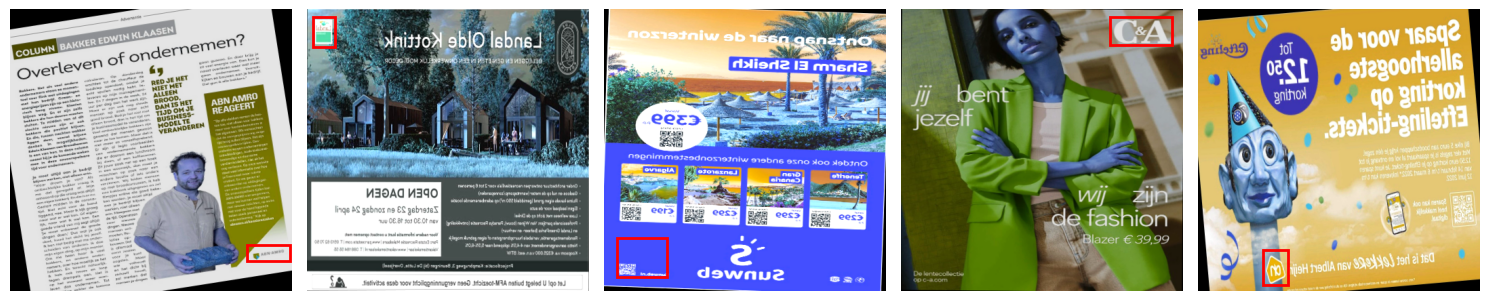

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa

def augment_and_visualize(images, adjusted_bboxes):
    """
    Applies data augmentation to a batch of images and adjusted bounding box coordinates,
    and visualizes a random sample of 5 augmented images with their adjusted bounding boxes.

    Args:
        images (numpy array): Array of preprocessed images (dtype: float32 or other).
        adjusted_bboxes (numpy array): Array of adjusted bounding box coordinates (dtype: int64).

    Returns:
        tuple: Tuple containing augmented images and corresponding adjusted bounding box coordinates.
    """
    # Convert images to uint8
    images = (images * 255).astype(np.uint8)

    # Define augmentation sequence
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # 50% horizontal flips
        iaa.Affine(rotate=(-10, 10)),  # rotate by -10 to 10 degrees
        iaa.Multiply((0.8, 1.2)),  # brightness change
        # iaa.GaussianBlur(sigma=(0.0, 3.0)),  # Gaussian blur
        # iaa.Dropout(p=(0, 0.2)),  # random dropout of pixels
        # iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),  # Gaussian noise
        # iaa.LinearContrast((0.8, 1.2)),  # linear contrast adjustment
        # iaa.Grayscale(alpha=(0.0, 1.0)),  # convert to grayscale with varying intensity
        # iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25),  # elastic transformation
        # iaa.PerspectiveTransform(scale=(0.01, 0.1)),  # random perspective transform
        # iaa.Cutout(nb_iterations=(1, 3), size=(0.1, 0.2), squared=False)  # random cutout
    ])

    # List to store resized images and new adjusted bounding boxes
    resized_images = []
    new_adjusted_bboxes = []

    # Iterate over each image and its corresponding bounding box
    for i in range(len(images)):
        image = images[i]
        bbox = adjusted_bboxes[i]

        # Convert bounding box to BoundingBoxesOnImage format
        bbox_list = [BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])]
        bbs = BoundingBoxesOnImage(bbox_list, shape=image.shape)

        # Apply augmentation to both image and bounding box
        aug_result = seq(image=image, bounding_boxes=bbs)

        # Unpack the augmented image and bounding box annotations from the tuple
        resized_image, augmented_bbs = aug_result

        # Extract adjusted bounding box coordinates
        adjusted_bbox = [
            augmented_bbs.bounding_boxes[0].x1_int,
            augmented_bbs.bounding_boxes[0].y1_int,
            augmented_bbs.bounding_boxes[0].x2_int,
            augmented_bbs.bounding_boxes[0].y2_int
        ]

        # Append resized image and adjusted bounding box to the lists
        resized_images.append(resized_image)
        new_adjusted_bboxes.append(adjusted_bbox)

    # Convert lists to numpy arrays
    resized_images = np.array(resized_images)
    new_adjusted_bboxes = np.array(new_adjusted_bboxes)

    # Visualize a random sample of 5 augmented images with their adjusted bounding boxes
    visualize_sample(resized_images, new_adjusted_bboxes, sample_size=5)

    return resized_images, new_adjusted_bboxes

def visualize_sample(images, adjusted_bboxes, sample_size=5):
    """
    Visualizes a random sample of augmented images along with their adjusted bounding boxes.

    Args:
        images (numpy array): Array of augmented images.
        adjusted_bboxes (numpy array): Array of adjusted bounding box coordinates.
        sample_size (int): Number of images to visualize (default: 5).
    """
    # Randomly select indices for the sample
    sample_indices = np.random.choice(len(images), sample_size, replace=False)

    # Create figure and axes for visualization
    fig, axes = plt.subplots(1, sample_size, figsize=(15, 5))

    # Iterate over sample indices and plot images with bounding boxes
    for i, idx in enumerate(sample_indices):
        ax = axes[i]
        image = images[idx]
        bbox = adjusted_bboxes[idx]

        # Plot image
        ax.imshow(image)
        ax.axis('off')

        # Plot adjusted bounding box
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        rect = plt.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming resized_images and adjusted_bboxes are populated with data
augmented_images, augmented_bboxes = augment_and_visualize(resized_images, adjusted_bboxes)

``Little more cleaning (inconsistencies in data and data types)``

In [12]:
# Check the shape of augmented images and bounding boxes
print("Shape of Augmented Images:", augmented_images.shape)
print("Shape of Augmented Bounding Boxes:", augmented_bboxes.shape)

Shape of Augmented Images: (595, 416, 416, 3)
Shape of Augmented Bounding Boxes: (595, 4)


In [14]:
print("Length of resized_images:", len(augmented_images))
print("Length of labels:", len(labels))
print("Length of adjusted_bboxes:", len(augmented_bboxes))

Length of resized_images: 595
Length of labels: 595
Length of adjusted_bboxes: 595


In [15]:
print("Type of resized_images:", type(augmented_images))
print("Type of labels:", type(labels))
print("Type of adjusted_bboxes:", type(augmented_bboxes))

Type of resized_images: <class 'numpy.ndarray'>
Type of labels: <class 'numpy.ndarray'>
Type of adjusted_bboxes: <class 'numpy.ndarray'>


In [16]:
import numpy as np

# Convert lists to NumPy arrays
resized_images = np.array(augmented_images)
labels = np.array(labels)
adjusted_bboxes = np.array(augmented_bboxes)

# Check the types of the converted arrays
print("Type of resized_images_np:", type(augmented_images))
print("Type of labels_np:", type(labels))
print("Type of adjusted_bboxes_np:", type(augmented_bboxes))

Type of resized_images_np: <class 'numpy.ndarray'>
Type of labels_np: <class 'numpy.ndarray'>
Type of adjusted_bboxes_np: <class 'numpy.ndarray'>


``Split train/test/validation with stratified sampling and shuffling``

To incorporate stratified sampling into the data splitting, I use the 'stratify' parameter available in the 'train_test_split' function from 'sklearn.model_selection'. This parameter ensures that the class distribution is maintained across the training, validation, and test sets. 

Before the stratified sampling, shuffling is incoporated to introduce randomness and prevent bisases that may arise. By shuffing data first, we ensure that each subset gets a random mix of examples from all classes. 

In [17]:
# Shuffle the data and labels together
shuffle_indices = np.random.permutation(len(augmented_images))
shuffled_images = augmented_images[shuffle_indices]
shuffled_labels = labels[shuffle_indices]
shuffled_bboxes = augmented_bboxes[shuffle_indices]

In [18]:
from sklearn.model_selection import train_test_split

# Split the shuffled data into training (80%) and temporary (20%) sets
train_data, temp_data, train_labels, temp_labels, train_bboxes, temp_bboxes = train_test_split(
    shuffled_images, shuffled_labels, shuffled_bboxes, test_size=0.2, random_state=42, stratify=shuffled_labels)

# Split the temporary set into validation (50%) and test (50%) sets
val_data, test_data, val_labels, test_labels, val_bboxes, test_bboxes = train_test_split(
    temp_data, temp_labels, temp_bboxes, test_size=0.5, random_state=42, stratify=temp_labels)

# Check the sizes of the splits
print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Training data shape: (476, 416, 416, 3)
Validation data shape: (59, 416, 416, 3)
Test data shape: (60, 416, 416, 3)


In [19]:
# Convert class labels to one-hot encoded vectors
num_classes = 17  # Number of classes in your dataset
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)


# Verify the shape of the one-hot encoded labels
print("Shape of train_labels_one_hot:", train_labels.shape)
print("Shape of val_labels_one_hot:", val_labels.shape)
print("Shape of test_labels_one_hot:", test_labels.shape)

Shape of train_labels_one_hot: (476, 17)
Shape of val_labels_one_hot: (59, 17)
Shape of test_labels_one_hot: (60, 17)


``Model architecture``

**Backbone: VGG-16**

In [21]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

# Load pre-trained VGG-16 model without including the top (fully connected) layers
vgg_backbone = VGG16(weights='imagenet', include_top=False, input_shape=(416, 416, 3))

# Freeze the convolutional layers of the VGG-16 backbone
for layer in vgg_backbone.layers:
    layer.trainable = False

**Backbone: ResNet50**

In [22]:
# import tensorflow as tf
# from tensorflow.keras.applications import ResNet50

# # Load pre-trained ResNet-50 model without including the top (fully connected) layers
# resnet_backbone = ResNet50(weights='imagenet', include_top=False, input_shape=(416, 416, 3))

# # Freeze the convolutional layers of the ResNet-50 backbone
# for layer in resnet_backbone.layers:
#     layer.trainable = False

**Region Proposal Network (RPN)**

In [60]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Input
from tensorflow.keras.regularizers import l2

# Define the input tensor for the RPN
rpn_input = vgg_backbone.output  # Output of the VGG-16 backbone
# rpn_input = resnet_backbone.output  # Output of the ResNet50 backbone

# Add a 3x3 convolutional layer with 512 filters and 'same' padding
rpn_conv = Conv2D(512, (3, 3), padding='same', activation='relu', name='rpn_conv')(rpn_input)

# # convolutional layer with regularization technique l2 and batchnormalization
# rpn_conv = Conv2D(512, (3, 3), padding='same', activation='relu', 
#                   kernel_regularizer=l2(0.01), name='rpn_conv')(rpn_input)
# rpn_conv_bn = BatchNormalization()(rpn_conv)

# Add a 1x1 convolutional layer for predicting objectness scores
objectness_scores = Conv2D(2, (1, 1), activation='softmax', name='objectness_scores')(rpn_conv)

# Add a 1x1 convolutional layer for predicting bounding box deltas
bbox_deltas = Conv2D(4, (1, 1), activation='linear', name='bbox_deltas')(rpn_conv)

# Define the input and output tensors for the RPN
# rpn_model = tf.keras.Model(inputs=vgg_backbone.input, outputs=[objectness_scores, bbox_deltas])
rpn_model = tf.keras.Model(inputs=vgg_backbone.input, outputs=[objectness_scores, bbox_deltas])

# Print the summary of the RPN model
# rpn_model.summary()

**Region of Interest Pooling (ROI)**

In [61]:
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, Concatenate
from tensorflow.keras.models import Model

# Define input tensor for ROI pooling
roi_input = rpn_model.output[0]  # Output of the RPN model

# Add a separate 2x2 MaxPooling2D layer for each output of the RPN model
pooling_layers = []
for output_tensor in rpn_model.output:
    pooling_layer = MaxPooling2D(pool_size=(2, 2))(output_tensor)
    pooling_layers.append(pooling_layer)

# Concatenate the pooled features along the channel axis
roi_pooling = Concatenate(axis=-1)(pooling_layers)

# Flatten the ROI pooled features
flattened_roi = Flatten()(roi_pooling)

# Add fully connected layers for classification and regression
fc1 = Dense(1024, activation='relu')(flattened_roi)
fc2 = Dense(1024, activation='relu')(fc1)

# # dense layers with regularizer and dropout
# fc1 = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(flattened_roi)
# dropout1 = Dropout(0.5)(fc1)  # Dropout layer with 50% probability
# fc2 = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(dropout1)

# Output layer for classification
num_classes = 17  # Example: 20 object classes + background (??)
classification_output = Dense(num_classes, activation='softmax', name='classification')(fc2)

# Output layer for bounding box regression
regression_output = Dense(4, activation='linear', name='regression')(fc2)

# Define input and output tensors for the ROI pooling model
roi_model = Model(inputs=rpn_model.input, outputs=[classification_output, regression_output])

# Print the summary of the ROI pooling model
# roi_model.summary()

**Bounding box regression and classification**

In [62]:
from tensorflow.keras.layers import Flatten, Dense

# Assuming rpn_model.output is a tuple containing multiple tensors
rpn_output_tensor = rpn_model.output[0]  # Choose the first tensor from the tuple

# Flatten the output of the RPN
rpn_output_flattened = Flatten()(rpn_output_tensor)

# Add fully connected layers for bounding box regression
bbox_regression_fc1 = Dense(512, activation='relu')(rpn_output_flattened)
bbox_regression_fc2 = Dense(512, activation='relu')(bbox_regression_fc1)
bbox_deltas_output = Dense(4, activation='linear', name='bbox_deltas')(bbox_regression_fc2)  # Output layer for bounding box regression

# Add fully connected layers for object classification
classification_fc1 = Dense(512, activation='relu')(rpn_output_flattened)
classification_fc2 = Dense(512, activation='relu')(classification_fc1)
num_classes = 17 # Example: 20 object classes + background
classification_output = Dense(num_classes, activation='softmax', name='classification')(classification_fc2)  # Output layer for classification

# Define input and output tensors for the model
final_model = tf.keras.Model(inputs=rpn_model.input, outputs=[classification_output, bbox_deltas_output])

# Print the summary of the final model
# final_model.summary()


**Loss function**

In [63]:
import tensorflow as tf

def rpn_classification_loss(y_true, y_pred):
    # y_true: true labels (1 for positive anchors, 0 for negative anchors, -1 for neutral anchors)
    # y_pred: predicted probabilities for objectness scores (softmax output)
    if tf.sparse.is_sparse(y_true):
        print("y_true is a SparseTensor")
    else:
        print("y_true is not a SparseTensor")
    
    # Filter out the neutral anchors (-1 labels)
    indices = tf.where(tf.not_equal(y_true, -1))
    y_true = tf.gather_nd(y_true, indices)
    y_pred = tf.gather_nd(y_pred, indices)
    
    # Compute binary cross-entropy loss
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    return tf.reduce_mean(loss)

def rpn_regression_loss(y_true, y_pred):
    # y_true: true bounding box deltas
    # y_pred: predicted bounding box deltas
    
    # Filter out the neutral anchors (-1 labels)
    indices = tf.where(tf.not_equal(tf.reduce_sum(tf.abs(y_true), axis=1), 0))
    y_true = tf.gather_nd(y_true, indices)
    y_pred = tf.gather_nd(y_pred, indices)
    
    # Compute smooth L1 loss
    loss = tf.keras.losses.Huber()(y_true, y_pred)
    
    return tf.reduce_mean(loss)

def rcnn_classification_loss(y_true, y_pred):
    # y_true: true class labels (one-hot encoded)
    # y_pred: predicted class probabilities
    
    # Compute categorical cross-entropy loss
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    
    return tf.reduce_mean(loss)

def rcnn_regression_loss(y_true, y_pred):
    # y_true: true bounding box deltas
    # y_pred: predicted bounding box deltas
    
    # Compute smooth L1 loss
    loss = tf.keras.losses.Huber()(y_true, y_pred)
    
    return tf.reduce_mean(loss)

# Combine the losses for RPN and RCNN
def total_loss(y_true, y_pred):
    rpn_cls_true, rpn_reg_true, rcnn_cls_true, rcnn_reg_true = y_true
    rpn_cls_pred, rpn_reg_pred, rcnn_cls_pred, rcnn_reg_pred = y_pred
    
    rpn_cls_loss = rpn_classification_loss(rpn_cls_true, rpn_cls_pred)
    rpn_reg_loss = rpn_regression_loss(rpn_reg_true, rpn_reg_pred)
    rcnn_cls_loss = rcnn_classification_loss(rcnn_cls_true, rcnn_cls_pred)
    rcnn_reg_loss = rcnn_regression_loss(rcnn_reg_true, rcnn_reg_pred)
    
    total_loss = rpn_cls_loss + rpn_reg_loss + rcnn_cls_loss + rcnn_reg_loss
    
    return total_loss

``Training``

In [64]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define initial hyperparameters
initial_learning_rate = 0.001
batch_size = 32
epochs = 5

# Define a learning rate schedule
def lr_schedule(epoch):
    """Learning Rate Schedule: start with initial learning rate and decay over epochs."""
    lr = initial_learning_rate
    if epoch >= 40:
        lr *= 0.1  # Reduce learning rate by 10x after 10 epochs
    return lr

# Compile the model with appropriate loss functions and metrics
final_model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
                    loss={'classification': rcnn_classification_loss, 'bbox_deltas': rcnn_regression_loss},
                    loss_weights={'classification': 1.0, 'bbox_deltas': 1.0},
                    metrics={'classification': 'accuracy', 'bbox_deltas': 'mae'})

# Define a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

A learning rate scheduler is a technique used in training deep learning models to adjust the learning rate dynamically during training. The learning rate is a critical hyperparameter that determines how much the weights of the neural network are updated during each iteration of optimization (e.g., gradient descent). An appropriate learning rate is essential for effective training: if the learning rate is too high, the training process may diverge, leading to unstable training and poor performance; if the learning rate is too low, the training may be slow and get stuck in local minima.

In [65]:
# Train the model with fine-tuned hyperparameters
history = final_model.fit(train_data, [train_labels, train_bboxes],
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(val_data, [val_labels, val_bboxes]),
                          callbacks=[lr_scheduler])

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 296s 20s/step - bbox_deltas_mae: 225.5698 - classification_accuracy: 0.0465 - loss: 228.0615 - val_bbox_deltas_mae: 175.8433 - val_classification_accuracy: 0.1186 - val_loss: 178.2082 - learning_rate: 0.0010
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 319s 21s/step - bbox_deltas_mae: 153.3506 - classification_accuracy: 0.0809 - loss: 155.6810 - val_bbox_deltas_mae: 119.9765 - val_classification_accuracy: 0.0847 - val_loss: 122.6102 - learning_rate: 0.0010
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 333s 22s/step - bbox_deltas_mae: 126.9233 - classification_accuracy: 0.0769 - loss: 129.3628 - val_bbox_deltas_mae: 111.9740 - val_classification_accuracy: 0.0847 - val_loss: 114.2235 - learning_rate: 0.0010
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 322s 22s/step - bbox_deltas_mae: 114.5314 - classification_accuracy: 0.1461 - loss: 116.7215 - val_bbox_deltas_mae: 112.1662 - val_classification_accuracy: 0.2542 - val_loss: 114.2126 - learning_rate: 0.0010
Epoch 5/5
15/15 ━━━━

``Evaluation``

In [66]:
# Evaluate the trained model on the test set
evaluation_results = final_model.evaluate(test_data, [test_labels, test_bboxes])

# Extract test loss and metrics from the evaluation results
test_loss = evaluation_results[0]  # First item is the total loss
test_metrics = evaluation_results[1:]  # Remaining items are the metrics

# Print test loss and metrics
print("Test Loss:", test_loss)
print("Test Metrics:", test_metrics)

2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 13s/step - bbox_deltas_mae: 108.5087 - classification_accuracy: 0.1528 - loss: 110.5523
Test Loss: 111.76406860351562
Test Metrics: [109.74016571044922, 0.1666666716337204]


In [67]:
final_model.save("rcnn_model2.keras")

``Plotting learning curve``

Look for signs of overfitting (increased validation loss or decreasing validation accuracy) as training progresses.

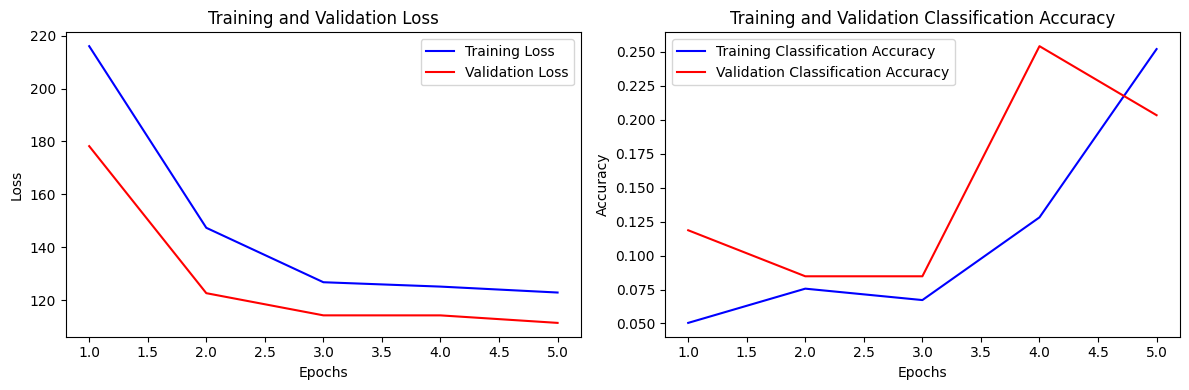

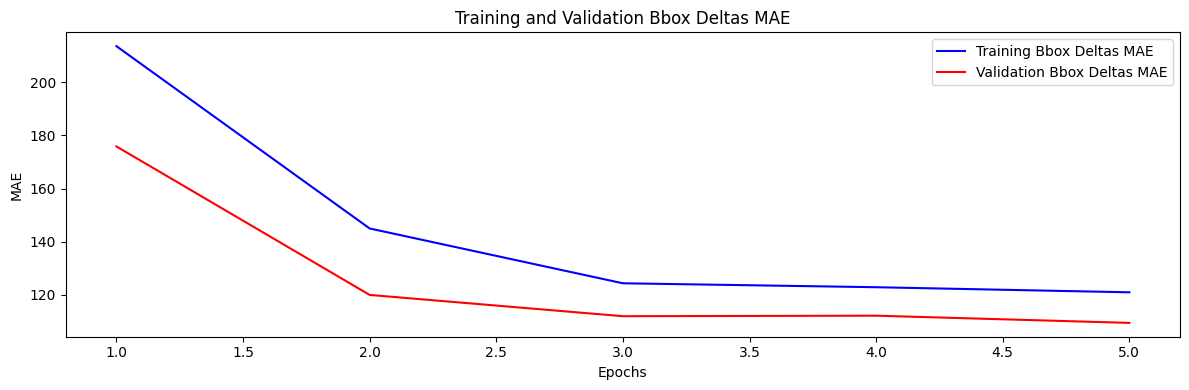

In [70]:
import matplotlib.pyplot as plt

# Extract available training and validation metrics from history object
loss = history.history['loss']
classification_accuracy = history.history['classification_accuracy']
bbox_deltas_mae = history.history['bbox_deltas_mae']
val_loss = history.history['val_loss']
val_classification_accuracy = history.history['val_classification_accuracy']
val_bbox_deltas_mae = history.history['val_bbox_deltas_mae']

epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation classification accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, classification_accuracy, 'b-', label='Training Classification Accuracy')
plt.plot(epochs, val_classification_accuracy, 'r-', label='Validation Classification Accuracy')
plt.title('Training and Validation Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot training and validation bounding box deltas MAE
plt.figure(figsize=(12, 4))
plt.plot(epochs, bbox_deltas_mae, 'b-', label='Training Bbox Deltas MAE')
plt.plot(epochs, val_bbox_deltas_mae, 'r-', label='Validation Bbox Deltas MAE')
plt.title('Training and Validation Bbox Deltas MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

``Testing and predicting``

**Testing**

In [71]:
# Make predictions on the test set
predictions = final_model.predict(test_data)

# Unpack the predictions
test_label_predictions, test_bbox_predictions = predictions

# Now 'test_label_predictions' contains the predicted labels
# and 'test_bbox_predictions' contains the predicted bounding boxes

2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 15s/step


``OUTPUT``

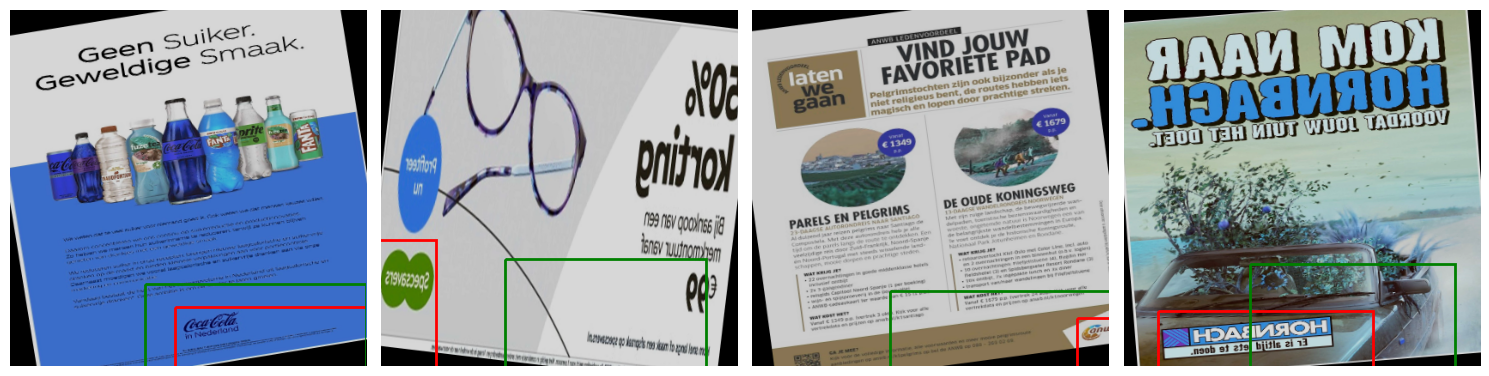

In [72]:
import matplotlib.pyplot as plt

# Function to plot images with bounding boxes
def plot_images_with_bboxes(images, true_bboxes, pred_bboxes):
    num_images = len(images)
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))

    for i, ax in enumerate(axes):
        # Plot image
        ax.imshow(images[i])
        ax.axis('off')

        # Plot true bounding box
        true_bbox = true_bboxes[i]
        ax.add_patch(plt.Rectangle((true_bbox[0], true_bbox[1]), true_bbox[2], true_bbox[3],
                                   edgecolor='r', facecolor='none', linewidth=2))

        # Plot predicted bounding box
        pred_bbox = pred_bboxes[i]
        ax.add_patch(plt.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3],
                                   edgecolor='g', facecolor='none', linewidth=2))

    plt.tight_layout()
    plt.show()

# Select a few random samples for visualization
num_samples_to_visualize = 4
random_indices = np.random.choice(len(test_data), num_samples_to_visualize, replace=False)

# Get the corresponding images, true bounding boxes, and predicted bounding boxes
visualize_images = [test_data[idx] for idx in random_indices]
true_bboxes_to_visualize = [test_bboxes[idx] for idx in random_indices]
pred_bboxes_to_visualize = [test_bbox_predictions[idx] for idx in random_indices]

# Plot the images with bounding boxes
plot_images_with_bboxes(visualize_images, true_bboxes_to_visualize, pred_bboxes_to_visualize)


# red = true, green = predicted